In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
import re, time, os

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.Unet_like import *   
# from custom_classes_defs.fnet import *
from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 32
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt

# from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

In [5]:
# Verify CPU setup
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")
print(tf.config.list_physical_devices('CPU'))

# Verify GPU setup
print(tf.config.list_physical_devices('GPU'))

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


In [48]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(seed=RND_STATE)

#for input_path, target_path in zip(pets.input_img_paths[:10], pets.target_img_paths[:10]):
#    print(input_path, "|", target_path)
print(f"training data (size = {len(train_dataset)*BATCH_SIZE})")
print(f"validation data (size = {len(valid_dataset)*BATCH_SIZE})")
print(f"test data (size = {len(test_dataset)*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])


Number of samples: 7390
training data (size = 672)
validation data (size = 96)
test data (size = 6656)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)


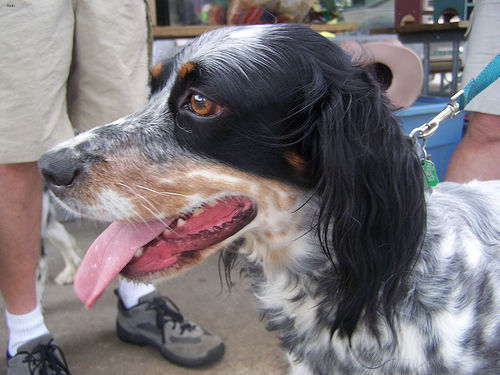

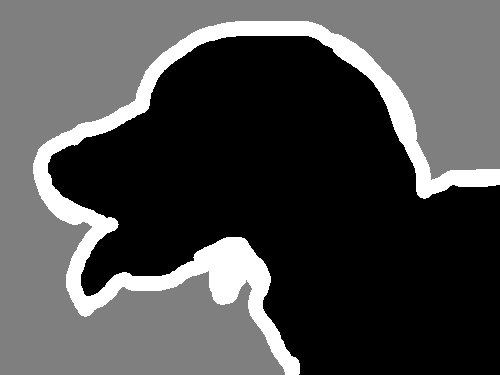

In [49]:
# Display input image #idx
idx = 19
display(Image(filename=pets.input_img_paths[idx]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(pets.target_img_paths[idx]))
display(img)

In [50]:

# Model configurations
conf = model_config(
    epochs=30,
    batch_size=BATCH_SIZE,
    shuffle=False,
    scaling=1,
    verbose=1,
    save_path='./data',
    augmentation=False,
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    new_training_session=True
)


es_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

callbacks = [
    #keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
    es_callbacks
]

conf.set( validation_data=valid_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    loss="sparse_categorical_crossentropy"
)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
       training_args:
                        epochs: 30
                    batch_size: 32
                       shuffle: False
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'tensorflow.python.trackable.data_structures.ListWrapper'>
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 1
                  augmentation: False
new_training_session: False
           save_path: ./data
           threshold: 0.5
           pos_label: 1


In [51]:
# ### Interactive step:
# if INTERACTIVE_SESSION:
#     train = input("New train session? (y/n): ")
#     if train[0].lower()=='y':
#         conf.new_training_session = True
#     else:
#         conf.new_training_session = False
#     interact = input("Are you sure, you want to run this session interactively? (y/n): ")
#     if interact[0].lower()!='y':
#         INTERACTIVE_SESSION = False

New train session? (y/n):  y
Are you sure, you want to run this session interactively? (y/n):  y


### Build model

In [52]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
model = m_obj.build_model()
# model.summary()
plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Total number of parameters: 14,716,313
Total trainable wieghts: 7,081,049
Total non-trainable wieghts: 7,635,264


### Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name+'_pets', 
    plot_history=INTERACTIVE_SESSION
)



### Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_preds = model.predict(valid_dataset)

if INTERACTIVE_SESSION:
    pets.display_sample_image(val_preds, image_id=10)
